In [6]:
import numpy as np
from matplotlib import pyplot as plt
import math
from math import exp, sqrt, pi
import time

import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset,RandomSampler

from mpl_toolkits import mplot3d

In [7]:
epochs = 40
device = torch.device("cpu")

eps = 1

learning_rate = 1e-3
batchflag = True
batchsize = 128

start = 0.
end = 1.
x = np.linspace(start,end,100 )
y = np.linspace(start,end,100)
x, y = np.meshgrid(x, y)
x = np.reshape(x, (np.size(x[:]),1))
y = np.reshape(y, (np.size(y[:]),1))

sinpix = np.array([[math.sin(math.pi*ind[0])] for ind in x])
sinpiy = np.array([[math.sin(math.pi*ind[0])] for ind in y])

actual_soln = ((sinpix)**2) * ((sinpiy)**2)

#f = 8*(eps**2)*((math.pi)**4)*(cos2pix*cos2piy - cos2pix*sinpiy*sinpiy - cos2piy*sinpix*sinpix) - 2*((math.pi)**2)*(cos2pix*sinpiy*sinpiy + cos2piy*sinpix*sinpix)

In [8]:

def train(device,x,y,eps,learning_rate,epochs,batch_flag,batch_size,actual_soln):

	if(batch_flag):
		xnet = torch.Tensor(x)
		ynet = torch.Tensor(y) 

		dataset = TensorDataset(xnet,ynet)
		dataloader = DataLoader(dataset, batch_size=batch_size,shuffle=True,num_workers = 0,drop_last = True )
		print(len(dataloader))
	else:
		xnet = torch.Tensor(x)
		ynet = torch.Tensor(y) 



	h_n = 128
	input_n = 2  
	class Swish(nn.Module):
		def __init__(self, inplace=True):
			super(Swish, self).__init__()
			self.inplace = inplace

		def forward(self, x):
			if self.inplace:
				x.mul_(torch.sigmoid(x))
				return x
			else:
				return x * torch.sigmoid(x)
	

	class Net(nn.Module):
		def __init__(self):
			super(Net, self).__init__()
			self.tanh = nn.Tanh()
			self.lin0 = nn.Linear(input_n,h_n)
			self.lin = nn.Linear(h_n,h_n)
			self.lin1 = nn.Linear(h_n,1)
			self.swish = Swish()
		def forward(self,x):		
			tanh1 = self.tanh(x)
			tanh2 = self.tanh(1 - x)
			tanh11 = (tanh1[:,0].unsqueeze(1))*(tanh1[:,1].unsqueeze(1))*(tanh1[:,0].unsqueeze(1))*(tanh1[:,1].unsqueeze(1))
			tanh22 = (tanh2[:,0].unsqueeze(1))*(tanh2[:,1].unsqueeze(1))*(tanh2[:,0].unsqueeze(1))*(tanh2[:,1].unsqueeze(1))
			x = self.lin0(x)
			x = self.swish(x)
			x = self.lin(x)
			x = self.swish(x)
			x = self.lin(x)
			x = self.swish(x)
			x = self.lin1(x)
			out = x*tanh11*tanh22
			return  out

	
	net = Net()#.to(device)
	
	def init_normal(m):
		if type(m) == nn.Linear:
			nn.init.kaiming_normal_(m.weight)

	net.apply(init_normal)

	optimizer = optim.Adam(net.parameters(), lr=learning_rate, betas = (0.9,0.99),eps = 10**-15)

	def Loss_criterion(xnet,ynet):
		xnet.requires_grad = True
		ynet.requires_grad = True
		points = torch.cat((xnet,ynet),1) 
		U = net(points)
		U = U.view(len(U),-1)
		
		soln = (torch.sin(np.pi*xnet))**2 * (torch.sin(np.pi*ynet))**2
		soln_x = torch.autograd.grad(soln,xnet,grad_outputs=torch.ones_like(xnet),create_graph = True,only_inputs=True)[0]
		soln_xx = torch.autograd.grad(soln_x,xnet,grad_outputs=torch.ones_like(xnet),create_graph = True,only_inputs=True)[0]
		soln_xxx = torch.autograd.grad(soln_xx,xnet,grad_outputs=torch.ones_like(xnet),create_graph = True,only_inputs=True)[0]
		soln_xxxx = torch.autograd.grad(soln_xxx,xnet,grad_outputs=torch.ones_like(xnet),create_graph = True,only_inputs=True)[0]
		soln_y = torch.autograd.grad(soln,ynet,grad_outputs=torch.ones_like(ynet),create_graph = True,only_inputs=True)[0]
		soln_yy = torch.autograd.grad(soln_y,ynet,grad_outputs=torch.ones_like(ynet),create_graph = True,only_inputs=True)[0]
		soln_yyy = torch.autograd.grad(soln_yy,ynet,grad_outputs=torch.ones_like(ynet),create_graph = True,only_inputs=True)[0]
		soln_yyyy = torch.autograd.grad(soln_yyy,ynet,grad_outputs=torch.ones_like(ynet),create_graph = True,only_inputs=True)[0]
		soln_xxy = torch.autograd.grad(soln_xx,ynet,grad_outputs=torch.ones_like(ynet),create_graph = True,only_inputs=True)[0]
		soln_xxyy = torch.autograd.grad(soln_xxy,ynet,grad_outputs=torch.ones_like(ynet),create_graph = True,only_inputs=True)[0]
		f = (eps**2)*(soln_xxxx + soln_yyyy + 2*soln_xxyy) - (soln_xx + soln_yy)
		
		
		U_x = torch.autograd.grad(U,xnet,grad_outputs=torch.ones_like(xnet),create_graph = True,only_inputs=True)[0]
		U_xx = torch.autograd.grad(U_x,xnet,grad_outputs=torch.ones_like(xnet),create_graph = True,only_inputs=True)[0]
		U_xxx = torch.autograd.grad(U_xx,xnet,grad_outputs=torch.ones_like(xnet),create_graph = True,only_inputs=True)[0]
		U_xxxx = torch.autograd.grad(U_xxx,xnet,grad_outputs=torch.ones_like(xnet),create_graph = True,only_inputs=True)[0]
		U_y = torch.autograd.grad(U,ynet,grad_outputs=torch.ones_like(ynet),create_graph = True,only_inputs=True)[0]
		U_yy = torch.autograd.grad(U_y,ynet,grad_outputs=torch.ones_like(ynet),create_graph = True,only_inputs=True)[0]
		U_yyy = torch.autograd.grad(U_yy,ynet,grad_outputs=torch.ones_like(ynet),create_graph = True,only_inputs=True)[0]
		U_yyyy = torch.autograd.grad(U_yyy,ynet,grad_outputs=torch.ones_like(ynet),create_graph = True,only_inputs=True)[0]
		U_xxy = torch.autograd.grad(U_xx,ynet,grad_outputs=torch.ones_like(ynet),create_graph = True,only_inputs=True)[0]
		U_xxyy = torch.autograd.grad(U_xxy,ynet,grad_outputs=torch.ones_like(ynet),create_graph = True,only_inputs=True)[0]
		loss1 = (eps**2)*(U_xxxx + U_yyyy + 2*U_xxyy) - (U_xx + U_yy) - f 
		
		return nn.MSELoss()(loss1,torch.zeros_like(loss1)) 

	def plot_net():
		points = torch.cat((xnet,ynet),1)
		U = net(points)
		z = U.detach().numpy()
		
		x = np.linspace(0.,1.,100);y = np.linspace(0.,1.,100)
		x,y = np.meshgrid(x,y)
		fig = plt.figure()
		ax = plt.axes(projection='3d')
		ax.plot_surface(x,y,z.reshape(100,100))
		plt.show()

	losses = []
	tic = time.time()

	xx = np.linspace(0.,1.,100);yy = np.linspace(0.,1.,100)
	xx,yy = np.meshgrid(xx,yy)

	if(batch_flag):
		for epoch in range(epochs):
			if epoch == 30:
				learning_rate = 0.00001
				new_optimizer = optim.Adam(net.parameters(), lr=learning_rate, betas = (0.9,0.99),eps = 10**-15)
				optimizer = new_optimizer
			for batch_idx, (x_in,y_in) in enumerate(dataloader):

				net.zero_grad()
				loss = Loss_criterion(x_in,y_in)
				loss.backward()

				optimizer.step() 
				if batch_idx % 20 ==0:
					print('Train Epoch: {} \tLoss: {:.10f}'.format(epoch, loss.item()))

			points = torch.cat((xnet,ynet),1)
			U = net(points)
			z = U.detach().numpy()
			actual_loss = np.square(actual_soln - z).mean()
			print('\nAfter Epoch {}, \t Actual solution loss: {:.10f}\n'.format(
				epoch, actual_loss))
			if epoch % 1 == 0:
				ax = plt.axes(projection='3d')
				ax.plot_surface(xx,yy,z.reshape(100,100))
				plt.show()
			
			losses.append([loss.item(),actual_loss])

	else:
		for epoch in range(epochs):
			if epoch == 50:
				learning_rate = 0.00001
				new_optimizer = optim.Adam(net.parameters(), lr=learning_rate, betas = (0.9,0.99),eps = 10**-15)
				optimizer = new_optimizer
		
			net.zero_grad()
			loss = Loss_criterion(xnet,ynet)
			loss.backward()
			
			optimizer.step() 
			points = torch.cat((xnet,ynet),1)
			U = net(points)
			z = U.detach().numpy()
			actual_loss = np.square(actual_soln - z).mean()
			print('\nAfter Epoch {}, \t Actual solution loss: {:.10f}\n'.format(
				epoch, actual_loss))
			if epoch % 5 == 0:
				ax = plt.axes(projection='3d')
				ax.plot_surface(xx,yy,z.reshape(100,100))
				plt.show()
			
			losses.append([loss.item(),actual_loss])

	toc = time.time()
	elapseTime = toc - tic
	print ("Time elapsed = ", elapseTime)

	net_in = torch.cat((xnet,ynet),1)
	output = net(net_in)  
	
	return output 

78
Train Epoch: 0 	Loss: 771956.5000000000
Train Epoch: 0 	Loss: 700247.3125000000
Train Epoch: 0 	Loss: 751266.0000000000
Train Epoch: 0 	Loss: 535615.0000000000

After Epoch 0, 	 Actual solution loss: 0.0476398941



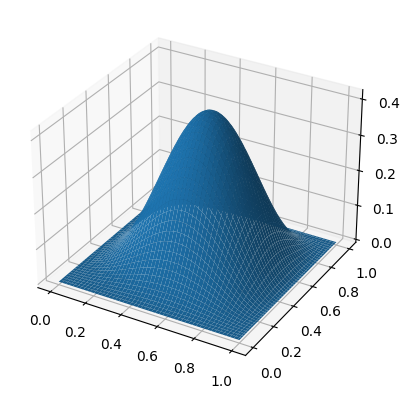

Train Epoch: 1 	Loss: 315518.0000000000
Train Epoch: 1 	Loss: 143030.9687500000
Train Epoch: 1 	Loss: 74816.6093750000
Train Epoch: 1 	Loss: 52263.1093750000

After Epoch 1, 	 Actual solution loss: 0.0003181521



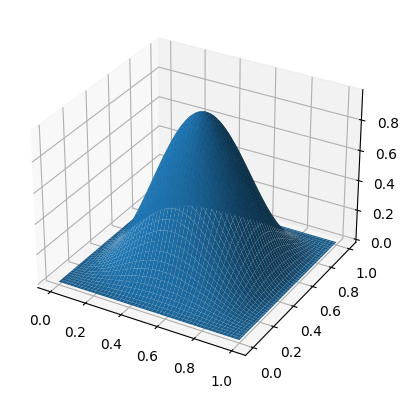

Train Epoch: 2 	Loss: 17236.5859375000
Train Epoch: 2 	Loss: 6990.1157226562
Train Epoch: 2 	Loss: 3027.8779296875
Train Epoch: 2 	Loss: 1867.0036621094

After Epoch 2, 	 Actual solution loss: 0.0000046915



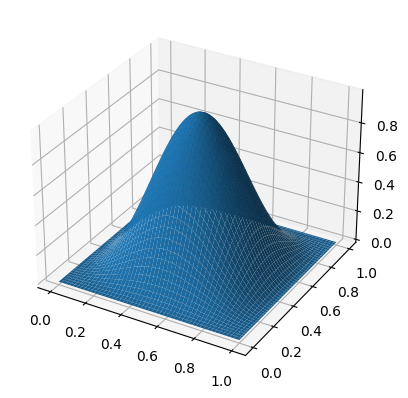

Train Epoch: 3 	Loss: 730.7449951172
Train Epoch: 3 	Loss: 643.8654785156
Train Epoch: 3 	Loss: 293.1441345215
Train Epoch: 3 	Loss: 294.8631591797

After Epoch 3, 	 Actual solution loss: 0.0000011504



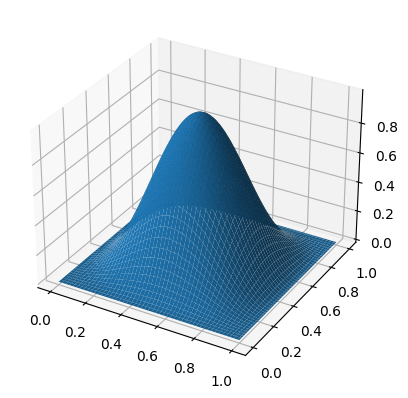

Train Epoch: 4 	Loss: 246.1652832031
Train Epoch: 4 	Loss: 240.3462829590
Train Epoch: 4 	Loss: 240.8153381348
Train Epoch: 4 	Loss: 190.8961944580

After Epoch 4, 	 Actual solution loss: 0.0000001918



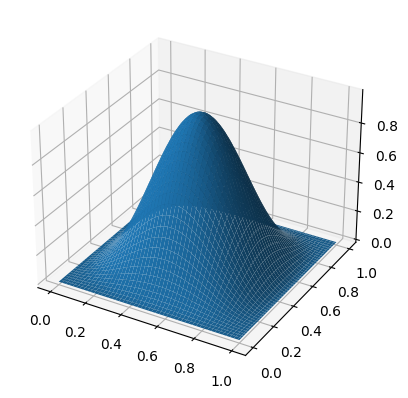

Train Epoch: 5 	Loss: 164.0594329834
Train Epoch: 5 	Loss: 144.5238647461
Train Epoch: 5 	Loss: 135.8210296631
Train Epoch: 5 	Loss: 71.4338607788

After Epoch 5, 	 Actual solution loss: 0.0000002022



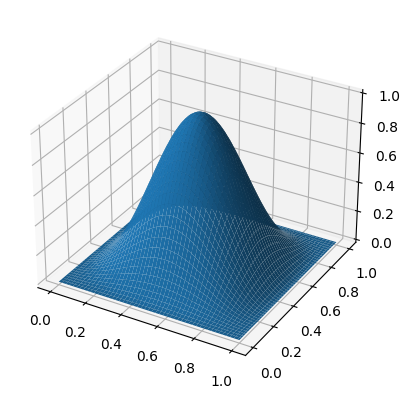

Train Epoch: 6 	Loss: 70.4300460815
Train Epoch: 6 	Loss: 59.6672859192
Train Epoch: 6 	Loss: 75.4862442017
Train Epoch: 6 	Loss: 76.8860549927

After Epoch 6, 	 Actual solution loss: 0.0000003236



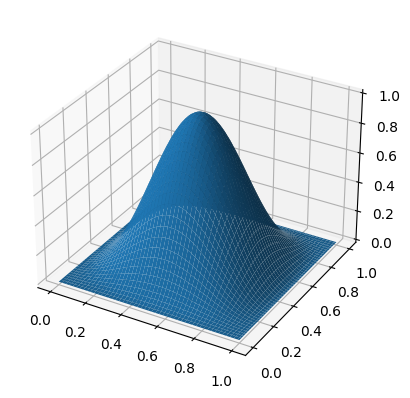

Train Epoch: 7 	Loss: 68.0121612549
Train Epoch: 7 	Loss: 81.0483932495
Train Epoch: 7 	Loss: 45.9263000488
Train Epoch: 7 	Loss: 58.6815834045

After Epoch 7, 	 Actual solution loss: 0.0000000171



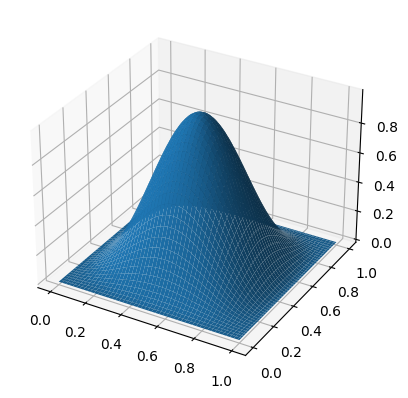

Train Epoch: 8 	Loss: 35.6871070862
Train Epoch: 8 	Loss: 37.9507026672
Train Epoch: 8 	Loss: 35.7361488342
Train Epoch: 8 	Loss: 30.2414722443

After Epoch 8, 	 Actual solution loss: 0.0000006272



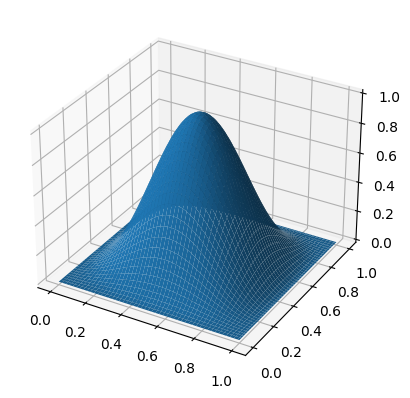

Train Epoch: 9 	Loss: 25.1315937042
Train Epoch: 9 	Loss: 20.1222496033
Train Epoch: 9 	Loss: 30.1729736328
Train Epoch: 9 	Loss: 23.5269546509

After Epoch 9, 	 Actual solution loss: 0.0000000483



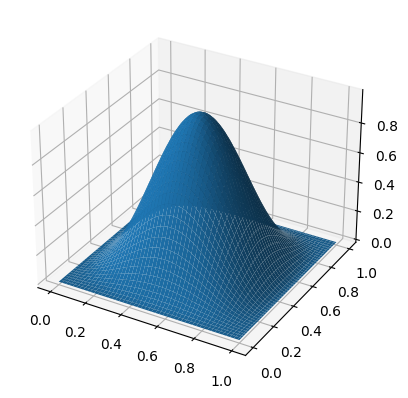

Train Epoch: 10 	Loss: 34.5573539734
Train Epoch: 10 	Loss: 32.5653762817
Train Epoch: 10 	Loss: 43.5630531311
Train Epoch: 10 	Loss: 26.8589744568

After Epoch 10, 	 Actual solution loss: 0.0000005199



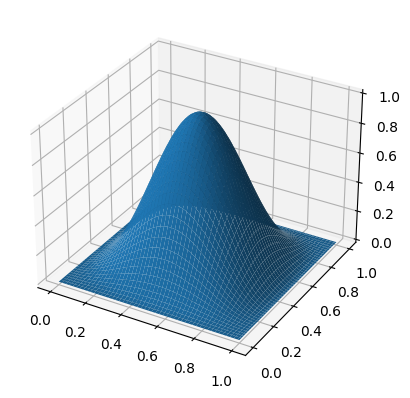

Train Epoch: 11 	Loss: 25.4323272705
Train Epoch: 11 	Loss: 26.6107139587
Train Epoch: 11 	Loss: 17.2914638519
Train Epoch: 11 	Loss: 19.2849521637

After Epoch 11, 	 Actual solution loss: 0.0000000706



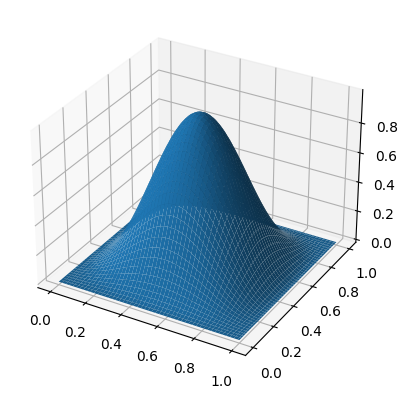

Train Epoch: 12 	Loss: 12.5057945251
Train Epoch: 12 	Loss: 17.0187454224
Train Epoch: 12 	Loss: 16.3561534882
Train Epoch: 12 	Loss: 22.8453750610

After Epoch 12, 	 Actual solution loss: 0.0000002307



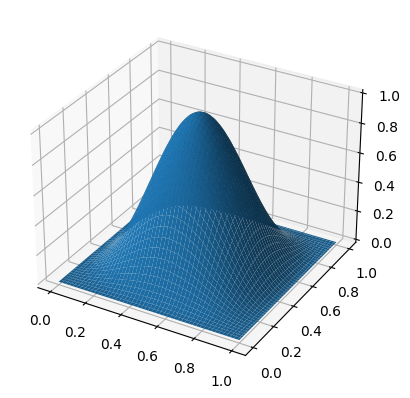

Train Epoch: 13 	Loss: 15.8202190399
Train Epoch: 13 	Loss: 18.1197662354
Train Epoch: 13 	Loss: 11.7614221573
Train Epoch: 13 	Loss: 9.0784807205

After Epoch 13, 	 Actual solution loss: 0.0000001057



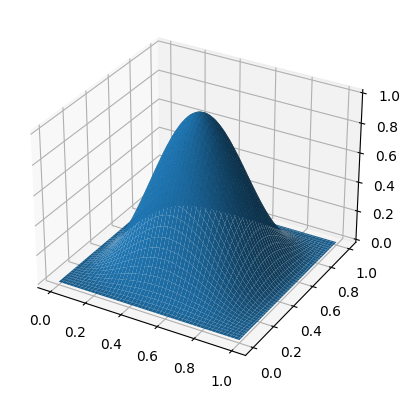

Train Epoch: 14 	Loss: 11.8792285919
Train Epoch: 14 	Loss: 9.5173788071
Train Epoch: 14 	Loss: 14.3240585327
Train Epoch: 14 	Loss: 7.5561876297

After Epoch 14, 	 Actual solution loss: 0.0000003159



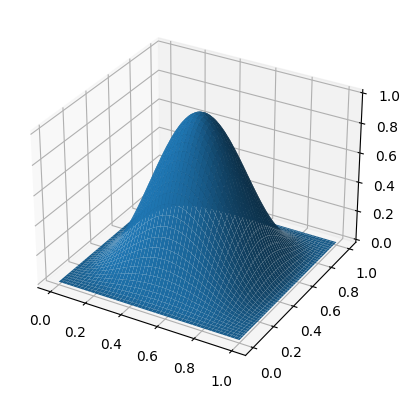

Train Epoch: 15 	Loss: 12.3577117920
Train Epoch: 15 	Loss: 11.9553184509
Train Epoch: 15 	Loss: 17.1105270386
Train Epoch: 15 	Loss: 12.2535943985

After Epoch 15, 	 Actual solution loss: 0.0000034824



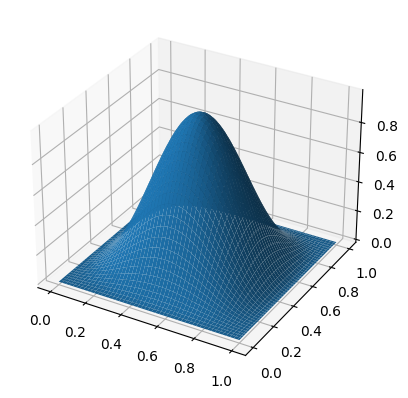

Train Epoch: 16 	Loss: 29.8998775482
Train Epoch: 16 	Loss: 20.9042263031
Train Epoch: 16 	Loss: 13.2661514282
Train Epoch: 16 	Loss: 10.9695987701

After Epoch 16, 	 Actual solution loss: 0.0000000542



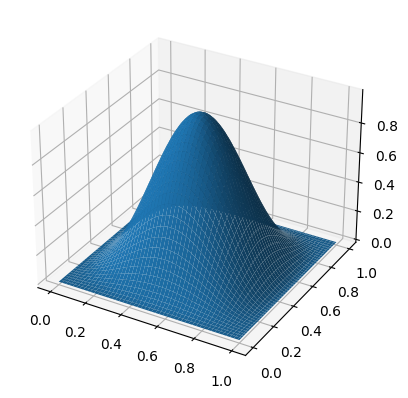

Train Epoch: 17 	Loss: 6.7265443802
Train Epoch: 17 	Loss: 5.6365456581
Train Epoch: 17 	Loss: 4.9526343346
Train Epoch: 17 	Loss: 4.4604749680

After Epoch 17, 	 Actual solution loss: 0.0000003008



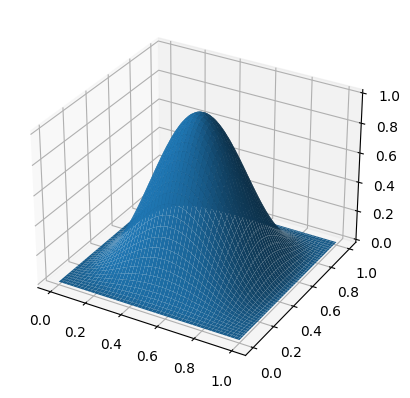

Train Epoch: 18 	Loss: 4.8770151138
Train Epoch: 18 	Loss: 2.9144878387
Train Epoch: 18 	Loss: 6.4779486656
Train Epoch: 18 	Loss: 3.3223764896

After Epoch 18, 	 Actual solution loss: 0.0000008067



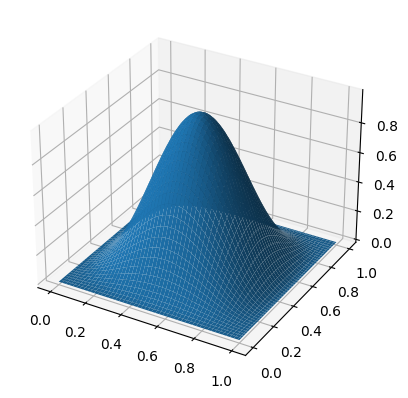

Train Epoch: 19 	Loss: 20.8377361298
Train Epoch: 19 	Loss: 8.9491710663
Train Epoch: 19 	Loss: 4.9790711403
Train Epoch: 19 	Loss: 6.8130025864

After Epoch 19, 	 Actual solution loss: 0.0000000066



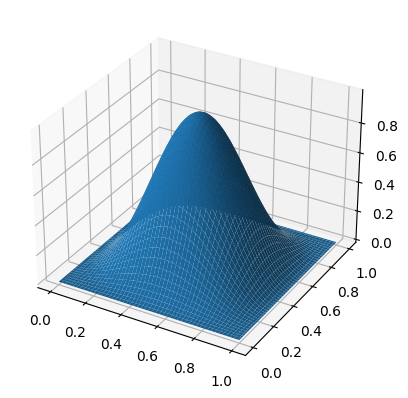

Train Epoch: 20 	Loss: 2.4128408432
Train Epoch: 20 	Loss: 7.7763414383
Train Epoch: 20 	Loss: 6.4870386124
Train Epoch: 20 	Loss: 3.5782527924

After Epoch 20, 	 Actual solution loss: 0.0000001142



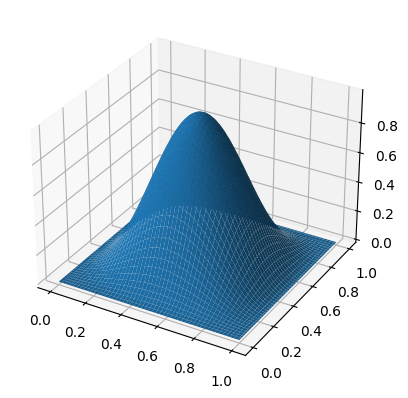

Train Epoch: 21 	Loss: 3.5346195698
Train Epoch: 21 	Loss: 6.5498437881
Train Epoch: 21 	Loss: 10.6137838364
Train Epoch: 21 	Loss: 13.2449531555

After Epoch 21, 	 Actual solution loss: 0.0000000483



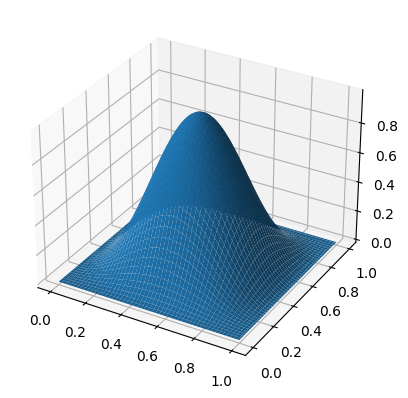

Train Epoch: 22 	Loss: 2.8136434555
Train Epoch: 22 	Loss: 2.7889776230
Train Epoch: 22 	Loss: 2.1111168861
Train Epoch: 22 	Loss: 2.8436560631

After Epoch 22, 	 Actual solution loss: 0.0000001541



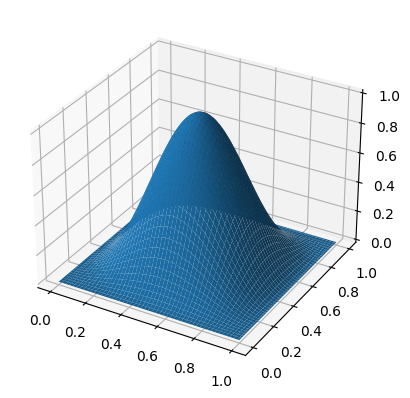

Train Epoch: 23 	Loss: 3.1477153301
Train Epoch: 23 	Loss: 3.3738310337
Train Epoch: 23 	Loss: 2.4477465153
Train Epoch: 23 	Loss: 1.8990336657

After Epoch 23, 	 Actual solution loss: 0.0000001070



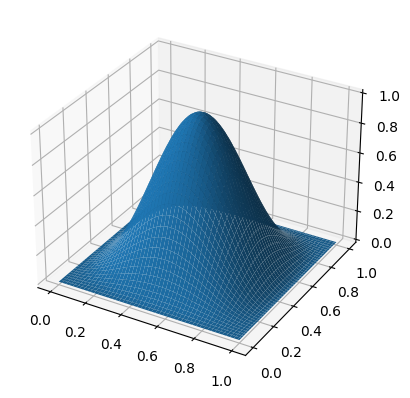

Train Epoch: 24 	Loss: 1.4621238708
Train Epoch: 24 	Loss: 1.0542193651
Train Epoch: 24 	Loss: 5.8741164207
Train Epoch: 24 	Loss: 1.5421421528

After Epoch 24, 	 Actual solution loss: 0.0000000788



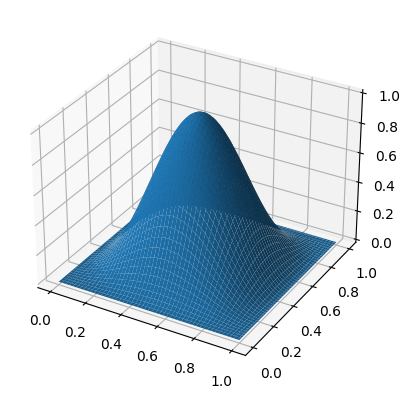

Train Epoch: 25 	Loss: 1.6301790476
Train Epoch: 25 	Loss: 12.8057918549
Train Epoch: 25 	Loss: 15.9560632706
Train Epoch: 25 	Loss: 5.9634790421

After Epoch 25, 	 Actual solution loss: 0.0000009751



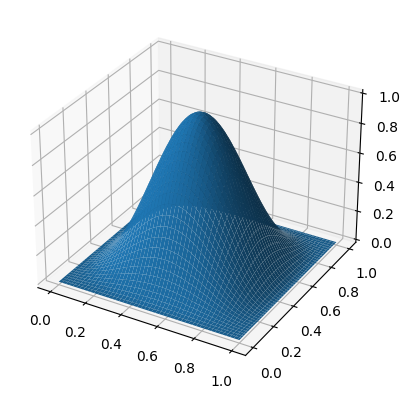

Train Epoch: 26 	Loss: 7.6627278328
Train Epoch: 26 	Loss: 2.3267712593
Train Epoch: 26 	Loss: 1.1900913715
Train Epoch: 26 	Loss: 0.9920035005

After Epoch 26, 	 Actual solution loss: 0.0000000033



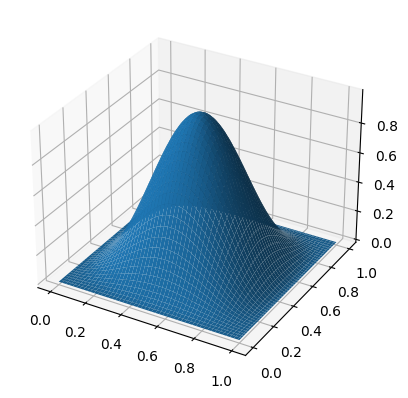

Train Epoch: 27 	Loss: 1.1772061586
Train Epoch: 27 	Loss: 1.3714540005
Train Epoch: 27 	Loss: 1.0537067652
Train Epoch: 27 	Loss: 1.4492007494

After Epoch 27, 	 Actual solution loss: 0.0000000556



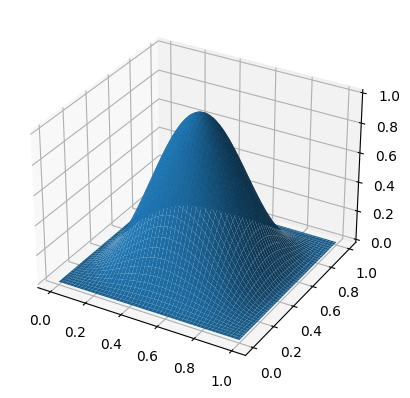

Train Epoch: 28 	Loss: 1.5902599096
Train Epoch: 28 	Loss: 2.0819473267
Train Epoch: 28 	Loss: 1.9508390427
Train Epoch: 28 	Loss: 1.2883422375

After Epoch 28, 	 Actual solution loss: 0.0000001379



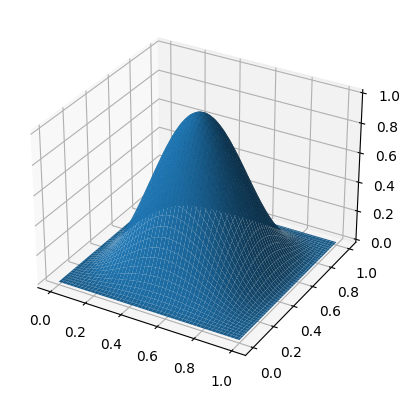

Train Epoch: 29 	Loss: 1.5195757151
Train Epoch: 29 	Loss: 8.8889894485
Train Epoch: 29 	Loss: 5.0452017784
Train Epoch: 29 	Loss: 17.8754386902

After Epoch 29, 	 Actual solution loss: 0.0000000434



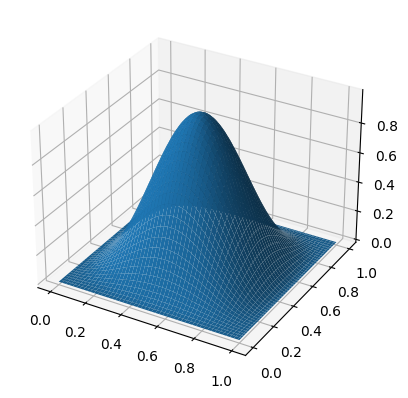

Train Epoch: 30 	Loss: 7.2111654282
Train Epoch: 30 	Loss: 3.2081320286
Train Epoch: 30 	Loss: 2.6114785671
Train Epoch: 30 	Loss: 1.6075470448

After Epoch 30, 	 Actual solution loss: 0.0000000021



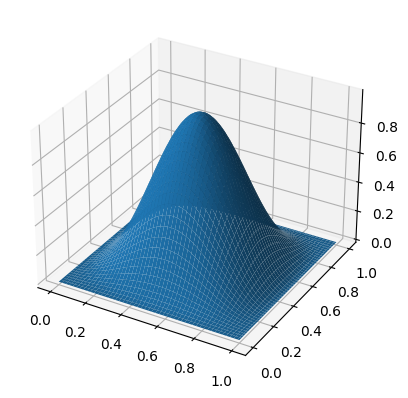

Train Epoch: 31 	Loss: 1.2617223263
Train Epoch: 31 	Loss: 1.1310340166
Train Epoch: 31 	Loss: 0.6889306307
Train Epoch: 31 	Loss: 0.9783586860

After Epoch 31, 	 Actual solution loss: 0.0000000126



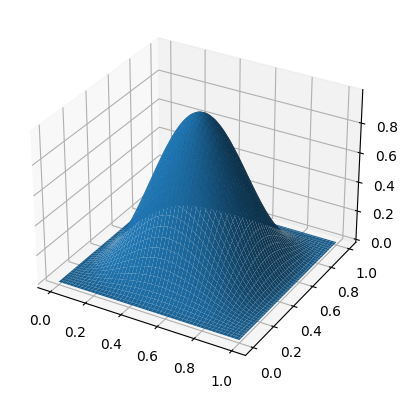

Train Epoch: 32 	Loss: 0.6677351594
Train Epoch: 32 	Loss: 0.9413604140
Train Epoch: 32 	Loss: 0.9115410447
Train Epoch: 32 	Loss: 0.6581413746

After Epoch 32, 	 Actual solution loss: 0.0000000078



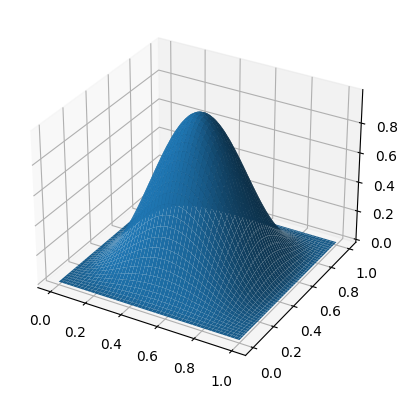

Train Epoch: 33 	Loss: 0.7909367681
Train Epoch: 33 	Loss: 0.5226030946
Train Epoch: 33 	Loss: 0.5497207046
Train Epoch: 33 	Loss: 0.5178434849

After Epoch 33, 	 Actual solution loss: 0.0000000149



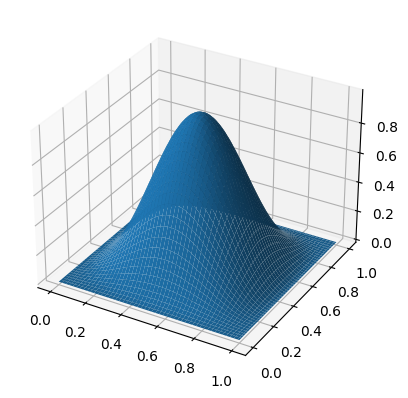

Train Epoch: 34 	Loss: 0.4400398731
Train Epoch: 34 	Loss: 0.3854685724
Train Epoch: 34 	Loss: 0.4268993437
Train Epoch: 34 	Loss: 0.4227248430

After Epoch 34, 	 Actual solution loss: 0.0000000049



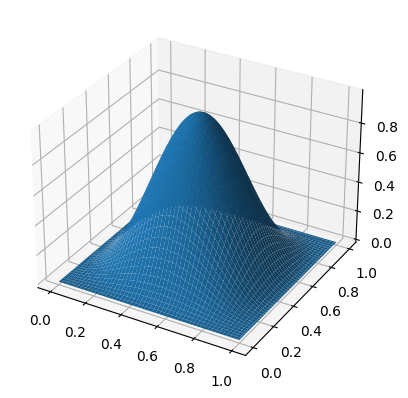

Train Epoch: 35 	Loss: 0.3607954979
Train Epoch: 35 	Loss: 0.4592124224
Train Epoch: 35 	Loss: 0.5105156302
Train Epoch: 35 	Loss: 0.6511402726

After Epoch 35, 	 Actual solution loss: 0.0000000039



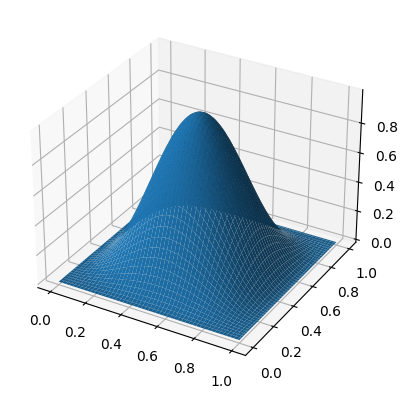

Train Epoch: 36 	Loss: 0.4549192488
Train Epoch: 36 	Loss: 0.3542098701
Train Epoch: 36 	Loss: 0.4040502608
Train Epoch: 36 	Loss: 0.4588988721

After Epoch 36, 	 Actual solution loss: 0.0000000036



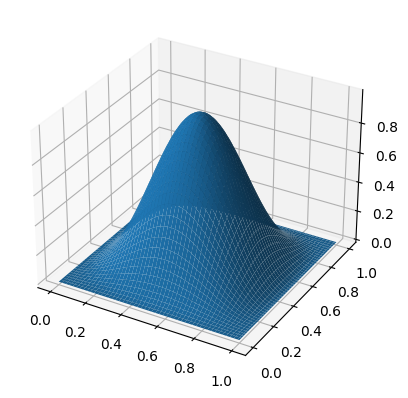

Train Epoch: 37 	Loss: 0.3310319781
Train Epoch: 37 	Loss: 0.5845797658
Train Epoch: 37 	Loss: 0.5132696033
Train Epoch: 37 	Loss: 0.5960251093

After Epoch 37, 	 Actual solution loss: 0.0000000112



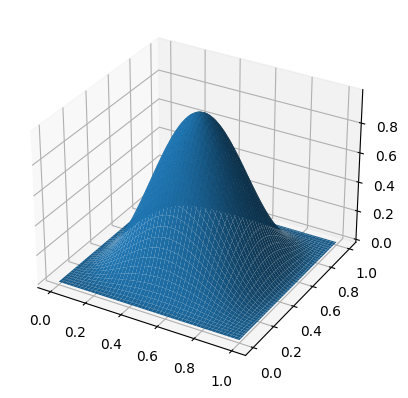

Train Epoch: 38 	Loss: 0.3970287442
Train Epoch: 38 	Loss: 0.4466534853
Train Epoch: 38 	Loss: 0.2695310712
Train Epoch: 38 	Loss: 0.3129897118

After Epoch 38, 	 Actual solution loss: 0.0000000062



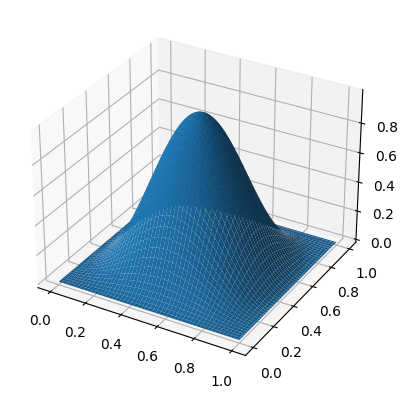

Train Epoch: 39 	Loss: 0.4998978972
Train Epoch: 39 	Loss: 0.4393616915
Train Epoch: 39 	Loss: 0.3801686764
Train Epoch: 39 	Loss: 0.5143274665

After Epoch 39, 	 Actual solution loss: 0.0000000071



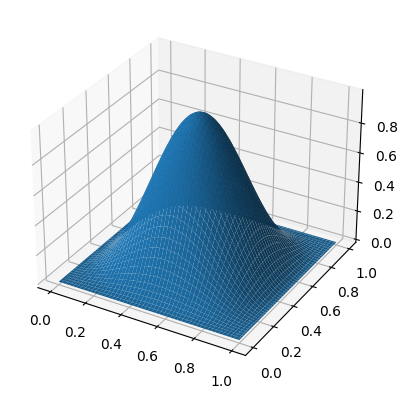

Time elapsed =  1496.9565563201904


In [9]:
output = train(device,x,y,eps,learning_rate,epochs,batchflag,batchsize,actual_soln)

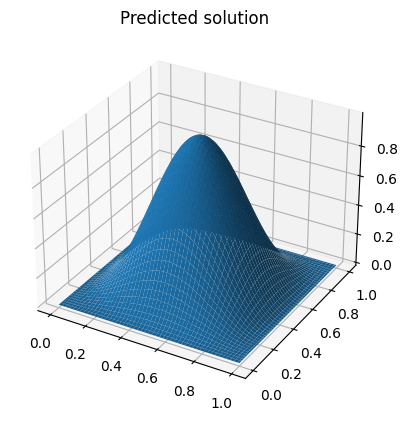

In [13]:
z = output.detach().numpy()
x = np.linspace(0.,1.,100);y = np.linspace(0.,1.,100)
x,y = np.meshgrid(x,y)
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.plot_surface(x,y,z.reshape(100,100))
plt.title('Predicted solution')
plt.show()

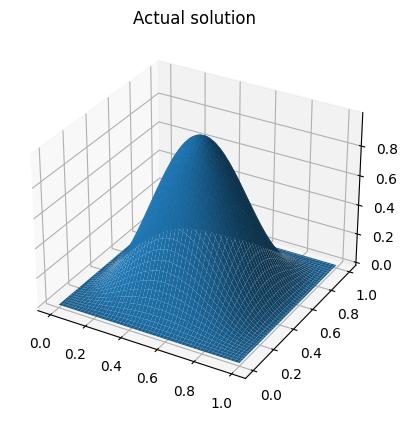

In [14]:
x = np.linspace(0.,1.,100);y = np.linspace(0.,1.,100)
x,y = np.meshgrid(x,y)
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.plot_surface(x,y,actual_soln.reshape(100,100))
plt.title('Actual solution')
plt.show()